In [1]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import control

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

# Predictores

Partiendo de la función estimada:

$$y[k] = G_e(z)u[k] + H_e(z)e[k]$$

Conociendo los valores de la entrada $u[k]$ y la salida $y[k]$, desconociendo la señal de error $e[k]$ y habiendo estimado $G_e$ y $H_e$, se puede usar dichas funciones de transferencia despejar el error desconocido, así:

$$e[k] = -H_e(z)^{-1}G_e(z)u[k] + H_e(z)^{-1}y[k]$$

Planteando que el error debe ser entre el modelo que se estima $y_e[k]$ y las mediciones $y[k]$, se puede decir que:

$$e[k] = y[k] - y_e[k]$$

Por lo tanto:

$$e[k] = y[k] - y_e[k] = -H_e(z)^{-1}G_e(z)u[k] + H_e(z)^{-1}y[k]$$

Despejando la estimación se obtendría:

$$y_e[k] = y[k] + H_e(z)^{-1}G_e(z)u[k] - H_e(z)^{-1}y[k]$$

$$y_e[k] = (1 - H_e(z)^{-1})y[k] + H_e(z)^{-1}G_e(z)u[k]$$

Reemplazando H y G por los valores de A(z) y B(z), se obtiene:

$$y_e[k] = (1 - A(z))y[k] + B(z)u[k]$$

## Ejemplo 2

Obtenda la señal estimada usando los polinomios calculados en el ejemplo anterior:

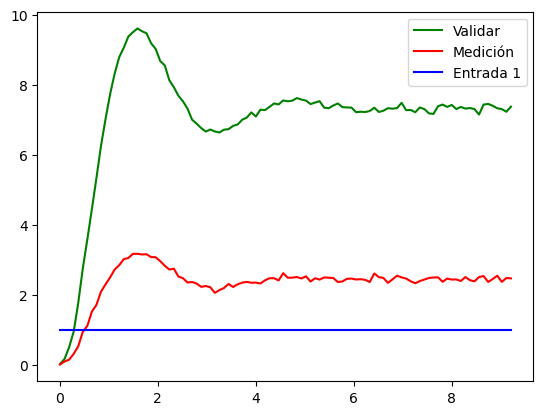

In [2]:
## Modelando la medición
## Sistema de segundo orden en tiempo continuo
g = control.tf([22],[2,3,9])

# Señal de salida ideal "y"

t,y = control.step_response(g)
dt = t[1]-t[0] 
N = len(t)
u = np.ones(N)

K2 = np.random.randint(2,4,dtype=int)
uv = K2*np.ones(N)
_,yv = control.step_response(K2*g,t)


## Ruido para simular la señal de salida capturada "yn" Entrenamiento y Validación
r = 0.06
e = np.random.normal(0,r,size=N)
yn = y+e
e = np.random.normal(0,r,size=N)
yv = yv+e

plt.plot(t,yv,color = 'green')
plt.plot(t,yn,color = 'red')
plt.plot(t,u,color = 'blue')
plt.legend(['Validar','Medición','Entrada 1'])

In [4]:
## Definir y_1, y_2, y_3, dependiendo el sistema que se quiera modelar
y_1 = np.zeros(N)
y_2 = np.zeros(N)
y_3 = np.zeros(N)
u_1 = np.zeros(N)
u_2 = np.zeros(N)
u_3 = np.zeros(N)

for k in range(1,N):
    y_1[k]=yn[k-1]
    u_1[k]=u[k-1]
for k in range(2,N):
    y_2[k]=yn[k-2]
    u_2[k]=u[k-2]
for k in range(3,N):
    y_3[k]=yn[k-3]
    u_3[k]=u[k-3]

In [5]:
## Creación del vector phi y un phi para validar
phi = np.array([y_1,y_2,y_3,u_1,u_2]).transpose()
# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.

alpha = 0.0
A = np.dot(phi.T,phi) + alpha*np.eye(len(np.dot(phi.T,phi)))
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,yn))
theta

array([ 0.97960488,  0.32766478, -0.39393619,  0.08681665,  0.13104368])

In [6]:
## DEFINIENDO UNA FUNCIÓN DE TRANSFERENCIA ## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)
## Construir los polinomios A(z) y B(z)
A = 1 - theta[0]*z**-1 - theta[1]*z**-2- theta[2]*z**-3  
B = theta[3]*z**-1+theta[4]*z**-2  

## Calcular la función de transferencia G y H en simbólica
G = B/A
G = G.simplify()
print(G)

z*(0.0868166531897998*z + 0.131043680660156)/(z**3 - 0.979604878439261*z**2 - 0.32766478469955*z + 0.393936187240001)


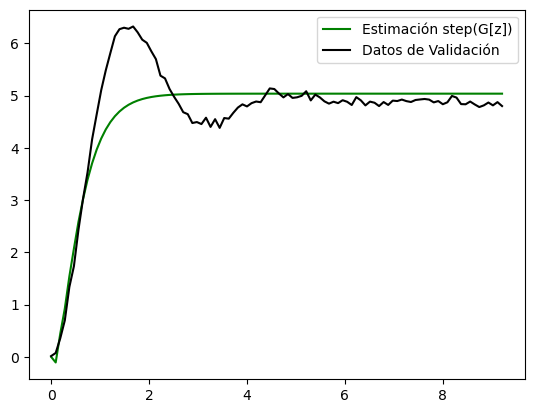

In [13]:
## Creando el Sys Din
Gz = control.tf([theta[3],theta[4],0],[1,-theta[0],-theta[1],-theta[2]],dt)
## Se usa la ganancia K2 por tomando datos de validación
_,ye1 = control.step_response(K2*Gz,t)

plt.plot(t,ye1,color = 'green')
plt.plot(t,yv,color = 'black')
plt.legend(['Estimación step(G[z])','Datos de Validación'])

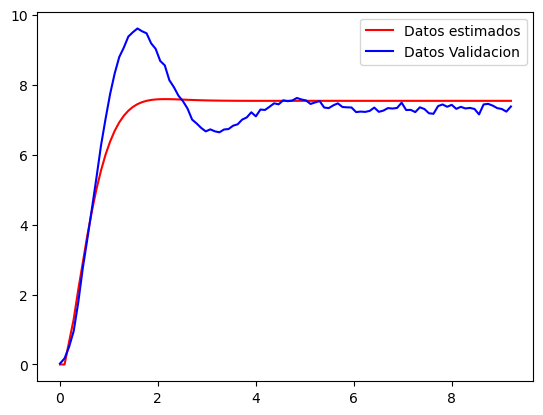

In [7]:
### Modelo 
### y_e = -y_1,-y_2,u_1,u_2
ye2 = np.zeros(N);

for k in range(2,N):
    ye2[k] = theta[0]*ye2[k-1] + theta[1]*ye2[k-2] + theta[2]*ye2[k-3] + theta[3]*uv[k-1]+ theta[4]*uv[k-2]   
    
plt.plot(t,ye2,color = 'red')
plt.plot(t,yv,color = 'blue')
plt.legend(["Datos estimados", "Datos Validacion"])